In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0
tf.config.experimental.set_memory_growth(physical_devices[0], True)
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

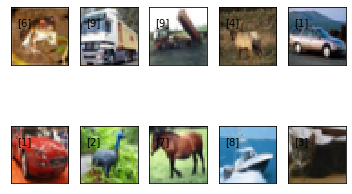

In [3]:
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(x_train[i-1])
    plt.text(3,10,str(y_train[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train,10)
y_test = tf.keras.utils.to_categorical(y_test,10)


In [5]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,[3,3],activation='tanh',
                          input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128,[3,3],activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128,[3,3],activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="tanh"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10,activation="softmax")
])

In [6]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         1

In [7]:
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                    validation_split=0.1,shuffle=True,
                   loss = tf.keras.losses.categorical_crossentropy,
                   metrics = ["accuracy"])

In [8]:
history = cnn_model.fit(x_train, y_train, validation_split=0.3, batch_size=128, epochs=10)

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 14s 390us/sample - loss: 2.3269 - accuracy: 0.1055 - val_loss: 2.2827 - val_accuracy: 0.1330
Epoch 2/10
35000/35000 [==============================] - 11s 306us/sample - loss: 2.2961 - accuracy: 0.1198 - val_loss: 2.2651 - val_accuracy: 0.1600
Epoch 3/10
35000/35000 [==============================] - 11s 304us/sample - loss: 2.2714 - accuracy: 0.1409 - val_loss: 2.2479 - val_accuracy: 0.1793
Epoch 4/10
35000/35000 [==============================] - 11s 306us/sample - loss: 2.2505 - accuracy: 0.1590 - val_loss: 2.2278 - val_accuracy: 0.2063
Epoch 5/10
35000/35000 [==============================] - 11s 305us/sample - loss: 2.2292 - accuracy: 0.1781 - val_loss: 2.2056 - val_accuracy: 0.2252
Epoch 6/10
35000/35000 [==============================] - 11s 307us/sample - loss: 2.2018 - accuracy: 0.1961 - val_loss: 2.1791 - val_accuracy: 0.2398
Epoch 7/10
35000/35000 [====================

In [9]:
cnn_model.evaluate(x_test,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.0627067710876466, 0.2762]

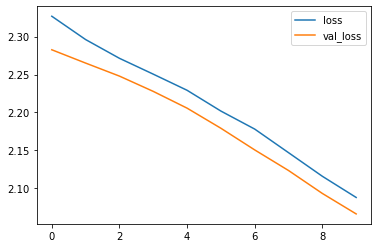

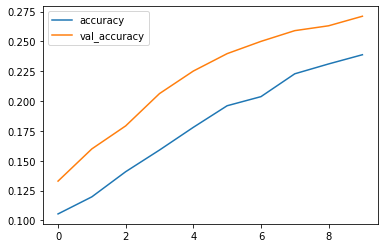

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## optional

In [11]:
import numpy as np
np.random.seed(1)

In [12]:
def conv_single_step(a_prev_slice,W,b):
    '''
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    Arguments:
    a_prev_slice: slice of input data (shape=(f,f,n_C_prev))
    W: Weight parameters contained in a window. (shape = (f,f,n_C_prev)) 卷积核参数
    b: Bias parameters contained in a window. (shape=(1,1,1))
    
    Reutrns:
    
    Z: a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data 
    '''
    # Element-wise product
    s = a_prev_slice * W 
    
    # Sum over s  
    Z = np.sum(s)
    
    # Add bias b to z.
    Z = Z + np.squeeze(b)
    
    return Z

In [13]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


In [14]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X: python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad: integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad: padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """

    X_pad = np.zeros((X.shape[0], X.shape[1] + 2*pad, X.shape[2] + 2*pad, X.shape[3]))
    X_pad[:, pad:X.shape[1] + pad, pad:X.shape[2] + pad, :] = X
    return X_pad

In [15]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [16]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev: output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W: Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b: Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters: python dictionary containing "stride" and "pad"
        
    Returns:
    Z: conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache: cache of values needed for the conv_backward() function
    """
    
    # Get dimensions from A_prev's shape  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape
    
    # Get information from "hparameters" 
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. 
    n_H = int((n_H_prev -f + 2*pad)/stride + 1)
    n_W = int((n_W_prev -f + 2*pad)/stride + 1)
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad               # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = stride * h
            vert_end = stride * h + f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice"
                horiz_start = stride * w
                horiz_end = stride * w + f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). 
                    a_slice_prev = a_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. 
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev,weights,biases)
                                        
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [17]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


In [18]:
def pool_forward(A_prev, hparameters, mode = "max"):
    # pooling层不改变channel
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev: Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters: python dictionary containing "f" and "stride"
    mode: the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A: output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache: cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Get dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = stride * h
            vert_end = stride * h + f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                horiz_start = stride * w
                horiz_end = stride * w + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [19]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [